<a href="https://colab.research.google.com/github/cqc232/C-CrashCourse/blob/master/SegNet_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The SegNet VGG 16 model notebook
cited from:

@article{badrinarayanan2017segnet,
  title={Segnet: A deep convolutional encoder-decoder architecture for image segmentation},
  author={Badrinarayanan, Vijay and Kendall, Alex and Cipolla, Roberto},
  journal={IEEE transactions on pattern analysis and machine intelligence},
  volume={39},
  number={12},
  pages={2481--2495},
  year={2017},
  publisher={IEEE}
}

In [10]:

%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from glob import glob
import pickle
import tensorflow as tf

In [11]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="6DUZXUzEElvb164kQwwY")
project = rf.workspace("pingworkspace").project("txlpbc-v2-vnadh")
version = project.version(1)
dataset = version.download("voc")


loading Roboflow workspace...
loading Roboflow project...


In [12]:
data_path = 'txlpbc-v2-1/'

train_path = "txlpbc-v2-1/train/"

valid_path = "txlpbc-v2-1/valid/"

test_path = "txlpbc-v2-1/test/"

# train_file = data_path + "train.p"
# valid_file = data_path + "val.p"
# test_file = data_path + "test.p"

In [13]:
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np

def class_name_to_id(class_name):
    class_map = {
        'PC': 0,  # Replace with actual class names
        'RBC': 1,
        'WBC': 2,
    }
    return class_map.get(class_name, -1)  # Default to -1 for unknown classes

def parse_xml(xml_file, image_shape, num_classes=3):
    # Initialize mask (2D) where 0 represents background
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    tree = ET.parse(xml_file)
    root = tree.getroot()

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        class_id = class_name_to_id(class_name)  # Assuming function to map class names to ids

        polygon = obj.find('polygon')
        if polygon is not None:
            # Extract polygon points
            points = []
            i = 1
            while True:
                x = polygon.find(f'x{i}')
                y = polygon.find(f'y{i}')
                if x is None or y is None:
                    break  # Exit if no more points
                points.append([int(float(x.text)), int(float(y.text))])
                i += 1

            if points:
                # Convert points list to a proper format for OpenCV (Nx2 array)
                points = np.array(points, dtype=np.int32)
                points = points.reshape((-1, 1, 2))  # Reshape to required format for fillPoly

                # Fill the polygon on the mask with the class ID
                cv2.fillPoly(mask, [points], class_id)

        else:
            # Fallback to bounding box if polygon is not available
            bbox = obj.find('bndbox')
            if bbox is not None:
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)

                # Draw class_id into the bounding box area of the mask
                mask[ymin:ymax, xmin:xmax] = class_id

    return mask

def make_dataset(image_dir, num_classes=3):
    images = []
    masks = []

    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            image_path = os.path.join(image_dir, filename)
            xml_path = os.path.join(image_dir, filename[:-4] + '.xml')  # Use the same filename for the XML

            # Read and resize the image to 224x224
            image = cv2.resize(cv2.imread(image_path), (224, 224))  # Assuming input size is 224x224
            images.append(image)

            # Parse the corresponding XML file to create the mask
            mask = parse_xml(xml_path, image.shape, num_classes)
            mask = cv2.resize(mask, (224, 224), interpolation=cv2.INTER_NEAREST)
            masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)
    return images, masks


# Directory containing your dataset
# image_dir = 'txlpbc-v2-1/train'
# X_train, y_train = make_dataset(image_dir, num_classes=3)


In [14]:
X_train, y_train = make_dataset(train_path)
X_val, y_val = make_dataset(valid_path)
X_test, y_test = make_dataset(test_path)

In [15]:
X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])

In [16]:
print(X_train.shape)
print(y_train.shape)

(365, 224, 224, 3)
(365, 224, 224)


(<Axes: >,
 (np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5)))

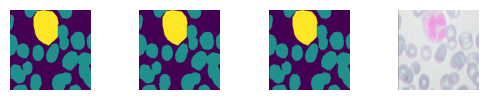

In [17]:
from matplotlib.gridspec import GridSpec
from random import randint, sample
ranidx = randint(0, len(y_train))
gs = GridSpec(4,4)
plt.figure(dpi=100)
for i in range(3):
    plt.subplot(gs[i]), plt.imshow(y_train[ranidx][:,:]), plt.axis('off')

plt.subplot(gs[3]), plt.imshow(X_train[ranidx]), plt.axis('off')

Error parsing XML file [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]: expected str, bytes or os.PathLike object, not ndarray
Error parsing XML file [[0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]: expected str, bytes or os.PathLike object, not ndarray
Error parsing XML file [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]: expected str, bytes or os.PathLike object, not ndarray
Error parsing XML file [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]: expected str, bytes or os.PathLike object, not ndarray


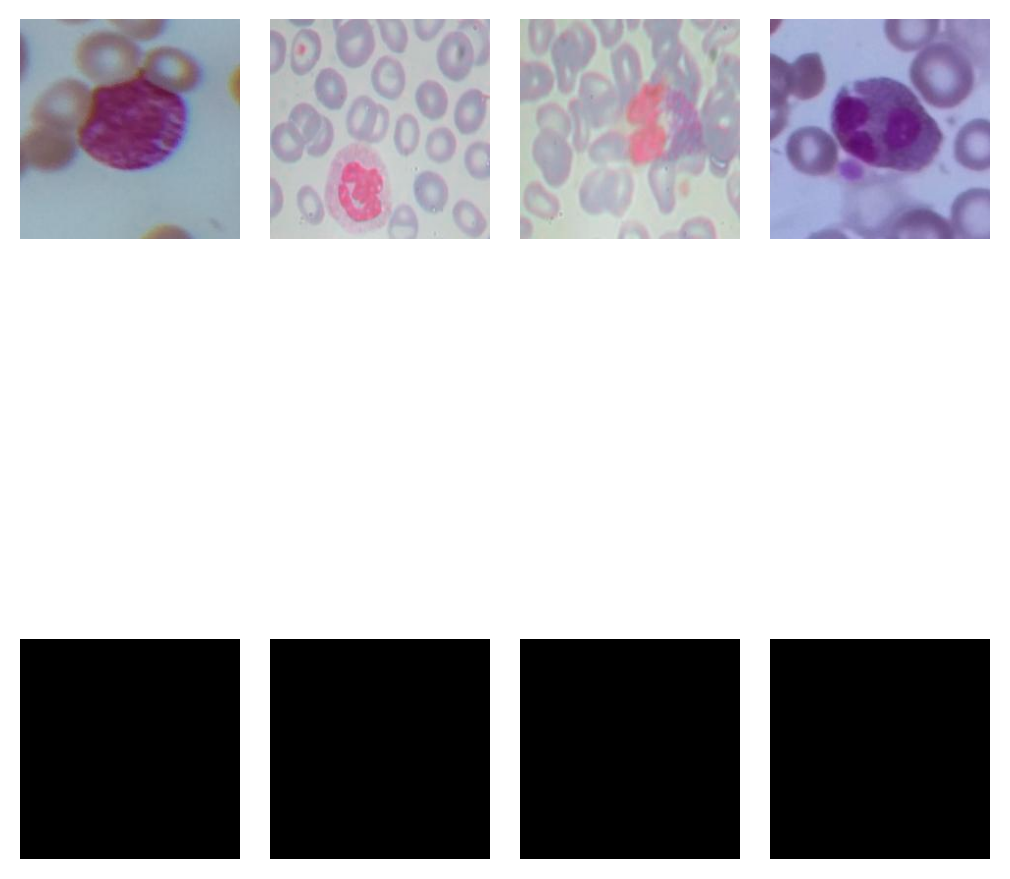

In [18]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# 定义缺失的 parse_xml_label 函数
def parse_xml_label(xml_path):
    """
    解析XML标注文件，返回标签掩码
    """
    try:
        # 解析XML文件
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # 获取图像尺寸
        size = root.find('size')
        if size is not None:
            width = int(size.find('width').text)
            height = int(size.find('height').text)
        else:
            # 默认尺寸
            width, height = 224, 224

        # 创建标签掩码
        label_mask = np.zeros((height, width), dtype=np.uint8)

        # 解析对象标注
        for obj in root.findall('object'):
            # 获取类别名称
            class_name = obj.find('name').text.lower()

            # 映射类别到标签ID
            if 'rbc' in class_name or 'red' in class_name:
                label_id = 1  # RBC
            elif 'wbc' in class_name or 'white' in class_name:
                label_id = 2  # WBC
            elif 'pc' in class_name or 'platelet' in class_name:
                label_id = 3  # PC (Platelet)
            else:
                label_id = 0  # Unlabelled

            # 获取边界框坐标
            bbox = obj.find('bndbox')
            if bbox is not None:
                xmin = int(float(bbox.find('xmin').text))
                ymin = int(float(bbox.find('ymin').text))
                xmax = int(float(bbox.find('xmax').text))
                ymax = int(float(bbox.find('ymax').text))

                # 确保坐标在有效范围内
                xmin = max(0, min(xmin, width - 1))
                xmax = max(0, min(xmax, width - 1))
                ymin = max(0, min(ymin, height - 1))
                ymax = max(0, min(ymax, height - 1))

                # 在掩码中标记对象区域
                label_mask[ymin:ymax, xmin:xmax] = label_id

        return label_mask

    except Exception as e:
        print(f"Error parsing XML file {xml_path}: {str(e)}")
        # 返回默认的空掩码
        return np.zeros((224, 224), dtype=np.uint8)

# 颜色定义
RBC = [128,0,0]
WBC = [60,40,222]
PC = [64,0,128]
Unlabelled = [0,0,0]

label_colours = np.array([Unlabelled, RBC, WBC, PC])

def visualize(temp, plot=True):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()

    for l in [0, 1, 2, 3]:  # 修改为包含所有标签
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)
    rgb[:,:,1] = (g/255.0)
    rgb[:,:,2] = (b/255.0)

    if plot:
        plt.imshow(rgb)
    else:
        return rgb

# 检查变量是否存在
if 'X_test' in locals() and 'y_test' in locals() and len(X_test) > 0 and len(y_test) > 0:
    randsample = [0, 1, 2, 3] if len(X_test) >= 4 else list(range(len(X_test)))
    gs = GridSpec(3, 5)
    plt.figure(dpi=200)

    for i in range(min(4, len(randsample))):
        if i < len(y_test) and i < len(X_test):
            ground_truth_path = y_test[randsample[i]]  # Path to XML ground truth file
            ground_truth_labels = parse_xml_label(ground_truth_path)
            ground_truth_visual = visualize(ground_truth_labels, plot=False)

            # 显示原图
            plt.subplot(gs[i])
            plt.imshow(X_test[randsample[i]])
            plt.axis('off')

            # 显示预测结果（如果存在output变量）
            if 'output' in locals():
                plt.subplot(gs[5+i])
                plt.imshow(output)
                plt.axis('off')

            # 显示真实标签
            plt.subplot(gs[10 + i])
            plt.imshow(ground_truth_visual)
            plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("请确保 X_test 和 y_test 变量已正确定义")

In [19]:
print(X_train.shape[1:] )

(224, 224, 3)


In [20]:
num_classes = 3
input_shape = X_train.shape[1:] #(480,480,3)
smooth = 1.
nproc = 8

In [21]:
pip install --user keras

In [22]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Activation, BatchNormalization
from keras.optimizers import Adam

# Create SegNet model for 3 classes
def segnet(input_shape=(224, 224, 3), num_classes=3):
    inputs = Input(shape=input_shape)

    # Encoder (same as VGG16)
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Decoder
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Final layer
    outputs = Conv2D(num_classes, (1, 1), padding='same')(x)
    outputs = Activation('softmax')(outputs)  # Use softmax for multi-class classification

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the model
model = segnet(input_shape=(224, 224, 3), num_classes=3)
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,08

 Total params: 29,459,075 (112.38 MB)

 Trainable params: 29,443,203 (112.32 MB)

 Non-trainable params: 15,872 (62.00 KB)

None


In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=8,
                    epochs=200,
                    shuffle=True)

Epoch 1/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 83s 759ms/step - accuracy: 0.4900 - loss: 0.9910
Epoch 2/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 315ms/step - accuracy: 0.5747 - loss: 0.7076
Epoch 3/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 319ms/step - accuracy: 0.5809 - loss: 0.6931
Epoch 4/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 322ms/step - accuracy: 0.5811 - loss: 0.6805
Epoch 5/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 324ms/step - accuracy: 0.5731 - loss: 0.6999
Epoch 6/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 328ms/step - accuracy: 0.5894 - loss: 0.6778
Epoch 7/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 326ms/step - accuracy: 0.5946 - loss: 0.6679
Epoch 8/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 325ms/step - accuracy: 0.5947 - loss: 0.6672
Epoch 9/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 327ms/step - accuracy: 0.5884 - loss: 0.6675
Epoch 10/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 325ms/step - accuracy: 0.6487 - loss: 0.6499
Epoch 11/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 326ms/step - accuracy: 0.7752 - loss: 0.4919
Epoch 12/200
46/46 ━━━━━━━━━━━

In [ ]:
history.history.keys()

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(X_test, verbose=1)

ranidx = randint(0, len(y_test))
gs = GridSpec(1,12)
plt.figure(dpi=200)
for i in range(12):
    plt.subplot(gs[i]), plt.imshow(pred[ranidx][:,:], cmap='jet'), plt.axis('off')

plt.figure(dpi=200)
for i in range(12):
    plt.subplot(gs[i]), plt.imshow(y_test[ranidx][:,:],cmap='jet'), plt.axis('off')

plt.figure(),plt.imshow(X_test[ranidx]), plt.axis('off')

In [ ]:
# refer from : https://github.com/preddy5/segnet/blob/master/Segnet.ipynb
#RBC = [128,128,128]
RBC = [128,0,0]
# Building = [128,0,0]
# Pole = [192,192,128]
# Road_marking = [255,69,0]
# Road = [128,64,128]
# Pavement = [60,40,222]
# WBC = [128,128,0]
WBC = [60,40,222]
# SignSymbol = [192,128,128]
# Fence = [64,64,128]
PC = [64,0,128]
# Pedestrian = [64,64,0]
# Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

#label_colours = np.array([RBC, WBC, PC, Unlabelled])
label_colours = np.array([Unlabelled,RBC, WBC, PC])
def visualize(temp, plot=True):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()

    for l in [0, 1, 2]:
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
    else:
        return rgb

# randsample = sample(range(0,len(pred)), 4)
randsample = [0, 1, 2, 3]
gs = GridSpec(3,5)
plt.figure(dpi=200)

for i in range(4):
    output = visualize(np.argmax(pred[randsample[i]],axis=2).reshape((224,224)), plot=False)
    #out_test = visualize(np.argmax(y_test[randsample[i]],axis=2).reshape((224,224)), plot=False)

    plt.subplot(gs[i]), plt.imshow(X_test[randsample[i]]), plt.axis('off')
    plt.subplot(gs[5+i]), plt.imshow(output), plt.axis('off')
    #plt.subplot(gs[10+i]), plt.imshow(out_test), plt.axis('off')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Color mappings
RBC = [128, 0, 0]
WBC = [60, 40, 222]
PC = [64, 0, 128]
Unlabelled = [0, 0, 0]
label_colours = np.array([Unlabelled, RBC, WBC, PC])

# Visualization function
def visualize(temp, plot=True):
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()

    for l in [0, 1, 2, 3]:  # Updated to include all labels in label_colours
        r[temp == l] = label_colours[l, 0]
        g[temp == l] = label_colours[l, 1]
        b[temp == l] = label_colours[l, 2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    if plot:
        plt.imshow(rgb)
    else:
        return rgb

# Sample data
randsample = [0, 1, 2, 3]
gs = GridSpec(3, 5)
plt.figure(dpi=200)

for i in range(4):
    # Display original image
    plt.subplot(gs[i]), plt.imshow(X_test[randsample[i]]), plt.axis('off')

    # Display model prediction
    output = visualize(np.argmax(pred[randsample[i]], axis=2).reshape((224, 224)), plot=False)
    plt.subplot(gs[5 + i]), plt.imshow(output), plt.axis('off')

    # Display ground truth from y_test
    ground_truth_visual = visualize(y_test[randsample[i]], plot=False)
    plt.subplot(gs[10 + i]), plt.imshow(ground_truth_visual), plt.axis('off')


In [ ]:
model.save('txlpbc-v2-1/blood_cell_segnet_model.h5')